In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch

from examples.dynamical_ball import dynamical_ball
from examples.bouncing_ball import bouncing_ball_data
from combinators.model import foldable
from combinators.inference import importance, mcmc
from combinators import utils

In [3]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [6]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [7]:
num_particles = (100,)

In [8]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [9]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    initial_position = inference['Reduce/Step(0)/InitBallDynamics']['position_0'].value
    initial_velocity = inference['Reduce/Step(0)/InitBallDynamics']['velocity_0'].value
    trajectory = dynamical_ball.simulate_trajectory(initial_position, initial_velocity, T)
    return trajectory[:, :, 0, :]

In [12]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [13]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [14]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Step(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [18]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return importance.Importance(init_bouncing_ball, init_proposal)

In [19]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(trainable=True, batch_shape=num_particles)
    return importance.Importance(bouncing_ball_step, step_proposal)

In [20]:
def training_model():
    return foldable.Reduce(foldable.Step(training_step(), initializer=training_initializer()), lambda: range(T))

02/22/2019 12:46:11 ELBO=-4.44320343e+02 at epoch 1
02/22/2019 12:46:11 ELBO=-4.53215973e+02 at epoch 2
02/22/2019 12:46:11 ELBO=-4.40328003e+02 at epoch 3
02/22/2019 12:46:11 ELBO=-4.24289886e+02 at epoch 4
02/22/2019 12:46:12 ELBO=-4.41096344e+02 at epoch 5
02/22/2019 12:46:12 ELBO=-4.02946503e+02 at epoch 6
02/22/2019 12:46:12 ELBO=-4.32808868e+02 at epoch 7
02/22/2019 12:46:13 ELBO=-4.11299561e+02 at epoch 8
02/22/2019 12:46:13 ELBO=-3.85873413e+02 at epoch 9
02/22/2019 12:46:13 ELBO=-3.82618256e+02 at epoch 10
02/22/2019 12:46:13 ELBO=-4.22683258e+02 at epoch 11
02/22/2019 12:46:14 ELBO=-4.07831299e+02 at epoch 12
02/22/2019 12:46:14 ELBO=-4.04848541e+02 at epoch 13
02/22/2019 12:46:14 ELBO=-4.05839966e+02 at epoch 14
02/22/2019 12:46:15 ELBO=-4.28309448e+02 at epoch 15
02/22/2019 12:46:15 ELBO=-3.99222321e+02 at epoch 16
02/22/2019 12:46:15 ELBO=-3.88574066e+02 at epoch 17
02/22/2019 12:46:16 ELBO=-3.80955963e+02 at epoch 18
02/22/2019 12:46:16 ELBO=-3.92823059e+02 at epoch 19
02

Epoch   411: reducing learning rate of group 0 to 5.0000e-03.


02/22/2019 12:48:27 ELBO=-2.36466080e+02 at epoch 413
02/22/2019 12:48:28 ELBO=-2.37403381e+02 at epoch 414
02/22/2019 12:48:28 ELBO=-2.56916779e+02 at epoch 415
02/22/2019 12:48:28 ELBO=-2.05722946e+02 at epoch 416
02/22/2019 12:48:29 ELBO=-2.48296280e+02 at epoch 417
02/22/2019 12:48:29 ELBO=-2.24116226e+02 at epoch 418
02/22/2019 12:48:29 ELBO=-2.29576462e+02 at epoch 419
02/22/2019 12:48:30 ELBO=-2.34081284e+02 at epoch 420
02/22/2019 12:48:30 ELBO=-2.52432571e+02 at epoch 421
02/22/2019 12:48:31 ELBO=-2.31491333e+02 at epoch 422
02/22/2019 12:48:31 ELBO=-2.50533401e+02 at epoch 423
02/22/2019 12:48:31 ELBO=-2.52867264e+02 at epoch 424
02/22/2019 12:48:32 ELBO=-2.47115524e+02 at epoch 425
02/22/2019 12:48:32 ELBO=-2.27157349e+02 at epoch 426
02/22/2019 12:48:32 ELBO=-2.53546860e+02 at epoch 427
02/22/2019 12:48:32 ELBO=-2.46648117e+02 at epoch 428
02/22/2019 12:48:33 ELBO=-2.11358459e+02 at epoch 429
02/22/2019 12:48:33 ELBO=-2.30085175e+02 at epoch 430
02/22/2019 12:48:34 ELBO=-2.

Epoch   610: reducing learning rate of group 0 to 2.5000e-03.


02/22/2019 12:49:35 ELBO=-2.22386475e+02 at epoch 613
02/22/2019 12:49:35 ELBO=-2.41450821e+02 at epoch 614
02/22/2019 12:49:35 ELBO=-2.43495911e+02 at epoch 615
02/22/2019 12:49:36 ELBO=-2.46013367e+02 at epoch 616
02/22/2019 12:49:36 ELBO=-2.37060760e+02 at epoch 617
02/22/2019 12:49:36 ELBO=-2.21719498e+02 at epoch 618
02/22/2019 12:49:37 ELBO=-2.34752533e+02 at epoch 619
02/22/2019 12:49:37 ELBO=-2.26930588e+02 at epoch 620
02/22/2019 12:49:37 ELBO=-2.28202866e+02 at epoch 621
02/22/2019 12:49:38 ELBO=-2.18100998e+02 at epoch 622
02/22/2019 12:49:38 ELBO=-2.18877426e+02 at epoch 623
02/22/2019 12:49:38 ELBO=-2.35455643e+02 at epoch 624
02/22/2019 12:49:39 ELBO=-2.35306259e+02 at epoch 625
02/22/2019 12:49:39 ELBO=-2.21161499e+02 at epoch 626
02/22/2019 12:49:39 ELBO=-2.24684311e+02 at epoch 627
02/22/2019 12:49:40 ELBO=-1.99647980e+02 at epoch 628
02/22/2019 12:49:40 ELBO=-2.04544556e+02 at epoch 629
02/22/2019 12:49:40 ELBO=-2.47697693e+02 at epoch 630
02/22/2019 12:49:41 ELBO=-2.

Epoch   711: reducing learning rate of group 0 to 1.2500e-03.


02/22/2019 12:50:08 ELBO=-2.22033417e+02 at epoch 713
02/22/2019 12:50:08 ELBO=-2.22705643e+02 at epoch 714
02/22/2019 12:50:09 ELBO=-2.28464691e+02 at epoch 715
02/22/2019 12:50:09 ELBO=-2.33229507e+02 at epoch 716
02/22/2019 12:50:09 ELBO=-2.28984070e+02 at epoch 717
02/22/2019 12:50:10 ELBO=-1.90936493e+02 at epoch 718
02/22/2019 12:50:10 ELBO=-2.11286209e+02 at epoch 719
02/22/2019 12:50:10 ELBO=-2.33551071e+02 at epoch 720
02/22/2019 12:50:11 ELBO=-2.14730194e+02 at epoch 721
02/22/2019 12:50:11 ELBO=-2.41989609e+02 at epoch 722
02/22/2019 12:50:11 ELBO=-2.18279312e+02 at epoch 723
02/22/2019 12:50:12 ELBO=-2.21952637e+02 at epoch 724
02/22/2019 12:50:12 ELBO=-2.01867249e+02 at epoch 725
02/22/2019 12:50:12 ELBO=-2.18418640e+02 at epoch 726
02/22/2019 12:50:13 ELBO=-2.29545624e+02 at epoch 727
02/22/2019 12:50:13 ELBO=-2.17419556e+02 at epoch 728
02/22/2019 12:50:13 ELBO=-2.27332947e+02 at epoch 729
02/22/2019 12:50:14 ELBO=-2.14980026e+02 at epoch 730
02/22/2019 12:50:14 ELBO=-1.

Epoch   812: reducing learning rate of group 0 to 6.2500e-04.


02/22/2019 12:50:42 ELBO=-2.19427597e+02 at epoch 815
02/22/2019 12:50:42 ELBO=-2.23877823e+02 at epoch 816
02/22/2019 12:50:43 ELBO=-2.31888412e+02 at epoch 817
02/22/2019 12:50:43 ELBO=-2.12597153e+02 at epoch 818
02/22/2019 12:50:43 ELBO=-2.25009964e+02 at epoch 819
02/22/2019 12:50:43 ELBO=-2.21275635e+02 at epoch 820
02/22/2019 12:50:44 ELBO=-2.13442703e+02 at epoch 821
02/22/2019 12:50:44 ELBO=-2.23538025e+02 at epoch 822
02/22/2019 12:50:44 ELBO=-2.25264984e+02 at epoch 823
02/22/2019 12:50:45 ELBO=-2.28180573e+02 at epoch 824
02/22/2019 12:50:45 ELBO=-2.27777527e+02 at epoch 825
02/22/2019 12:50:45 ELBO=-2.09220764e+02 at epoch 826
02/22/2019 12:50:46 ELBO=-2.28833649e+02 at epoch 827
02/22/2019 12:50:46 ELBO=-2.14440308e+02 at epoch 828
02/22/2019 12:50:46 ELBO=-2.21089951e+02 at epoch 829
02/22/2019 12:50:47 ELBO=-1.99798569e+02 at epoch 830
02/22/2019 12:50:47 ELBO=-1.97899429e+02 at epoch 831
02/22/2019 12:50:47 ELBO=-2.24454163e+02 at epoch 832
02/22/2019 12:50:48 ELBO=-2.

Epoch   913: reducing learning rate of group 0 to 3.1250e-04.


02/22/2019 12:51:13 ELBO=-2.28801559e+02 at epoch 915
02/22/2019 12:51:14 ELBO=-2.02126053e+02 at epoch 916
02/22/2019 12:51:14 ELBO=-2.32136520e+02 at epoch 917
02/22/2019 12:51:14 ELBO=-1.95392914e+02 at epoch 918
02/22/2019 12:51:15 ELBO=-2.21361145e+02 at epoch 919
02/22/2019 12:51:15 ELBO=-2.23361862e+02 at epoch 920
02/22/2019 12:51:15 ELBO=-2.27872559e+02 at epoch 921
02/22/2019 12:51:16 ELBO=-2.08054672e+02 at epoch 922
02/22/2019 12:51:16 ELBO=-2.33720428e+02 at epoch 923
02/22/2019 12:51:16 ELBO=-2.28121994e+02 at epoch 924
02/22/2019 12:51:17 ELBO=-2.22704391e+02 at epoch 925
02/22/2019 12:51:17 ELBO=-1.91365387e+02 at epoch 926
02/22/2019 12:51:17 ELBO=-2.15800201e+02 at epoch 927
02/22/2019 12:51:18 ELBO=-2.09818665e+02 at epoch 928
02/22/2019 12:51:18 ELBO=-2.25405380e+02 at epoch 929
02/22/2019 12:51:18 ELBO=-2.30305420e+02 at epoch 930
02/22/2019 12:51:19 ELBO=-2.11947662e+02 at epoch 931
02/22/2019 12:51:19 ELBO=-2.15619247e+02 at epoch 932
02/22/2019 12:51:19 ELBO=-2.

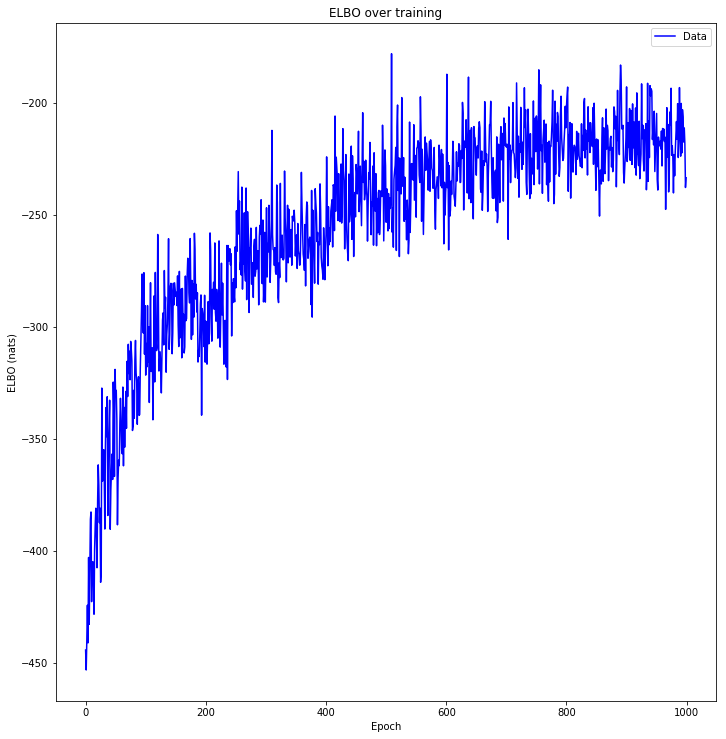

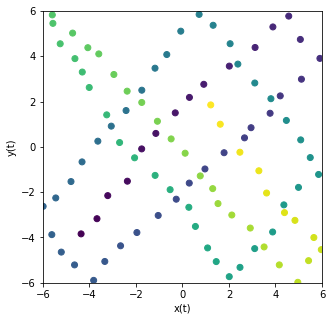

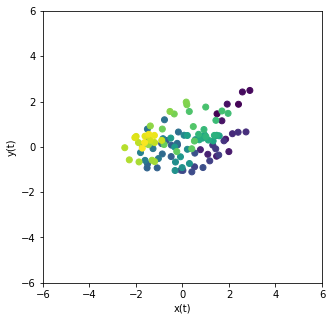

In [21]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-2, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.reduce_resample_move_smc(importance_sampler.folder.operator, lambda: range(T),
                                                            initializer=importance_sampler.folder._initializer, moves=5)
    (direction, position, uncertainty, noise), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Step(%d)/StepBallDynamics' % t]['velocity_%d' % (t+1)].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [22]:
trained_params

"{'noise__loc': 'tensor([-0.1584, -0.2542], grad_fn=<CloneBackward>)', 'noise__scale': 'tensor([-0.5056, -0.9036], grad_fn=<CloneBackward>)', 'position_0__covariance_matrix': 'tensor([[0.6787, 0.0000],\n        [1.2513, 0.0598]], grad_fn=<CloneBackward>)', 'position_0__loc': 'tensor([-2.0919, -2.2145], grad_fn=<CloneBackward>)', 'uncertainty__loc': 'tensor([-0.5538, -0.7920], grad_fn=<CloneBackward>)', 'uncertainty__scale': 'tensor([1.0812, 0.4895], grad_fn=<CloneBackward>)', 'velocity_0__loc': 'tensor([0.6496, 1.2198], grad_fn=<CloneBackward>)', 'velocity_0__scale': 'tensor([0.7997, 0.6865], grad_fn=<CloneBackward>)'}"

In [23]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-4.3595, -3.8397])
Position at time 1 tensor([-3.6763, -3.1699])
Position at time 2 tensor([-3.2129, -2.1507])
Position at time 3 tensor([-2.3687, -1.5139])
Position at time 4 tensor([-1.7538, -0.0884])
Position at time 5 tensor([-1.1445,  0.5955])
Position at time 6 tensor([-0.3093,  1.5030])
Position at time 7 tensor([0.3007, 2.1853])
Position at time 8 tensor([0.9178, 2.7637])
Position at time 9 tensor([2.0158, 3.5668])
Position at time 10 tensor([3.1242, 4.3897])
Position at time 11 tensor([3.8900, 5.2967])
Position at time 12 tensor([4.5717, 5.7750])
Position at time 13 tensor([5.0710, 4.7446])
Position at time 14 tensor([5.9126, 3.9075])
Position at time 15 tensor([5.1176, 2.9890])
Position at time 16 tensor([4.2065, 2.2527])
Position at time 17 tensor([3.7699, 1.4856])
Position at time 18 tensor([2.9508, 0.8479])
Position at time 19 tensor([2.6693, 0.3997])
Position at time 20 tensor([ 1.7907, -0.2566])
Position at time 21 tensor([ 0.9679, -0.9738])
Po

In [24]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([1.4875, 1.4606])
Inferred position at time 1 tensor([2.4106, 1.8823])
Inferred position at time 2 tensor([2.8993, 2.4928])
Inferred position at time 3 tensor([2.5790, 2.4252])
Inferred position at time 4 tensor([1.9255, 1.8888])
Inferred position at time 5 tensor([1.6961, 1.1533])
Inferred position at time 6 tensor([1.8574, 0.3411])
Inferred position at time 7 tensor([ 1.9966, -0.2076])
Inferred position at time 8 tensor([ 1.4680, -0.4115])
Inferred position at time 9 tensor([ 1.0911, -0.3266])
Inferred position at time 10 tensor([ 0.7719, -0.1223])
Inferred position at time 11 tensor([1.4188, 0.4944])
Inferred position at time 12 tensor([2.1494, 0.5818])
Inferred position at time 13 tensor([2.7334, 0.6615])
Inferred position at time 14 tensor([2.3940, 0.6479])
Inferred position at time 15 tensor([1.7856, 0.2691])
Inferred position at time 16 tensor([1.3034, 0.0797])
Inferred position at time 17 tensor([ 1.4315, -0.0852])
Inferred position at time 18

In [25]:
bouncing_ball_smc = importance.reduce_smc(importance_sampler.folder.operator, lambda: range(T), initializer=importance_sampler.folder._initializer)
(direction, position, uncertainty, noise), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [26]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-1.9634, -2.2118])
Inferred position at time 1 tensor([-1.3448, -0.9615])
Inferred position at time 2 tensor([-0.7142,  0.2888])
Inferred position at time 3 tensor([-0.2983,  1.3252])
Inferred position at time 4 tensor([-0.2473,  1.7154])
Inferred position at time 5 tensor([-0.2869,  1.5752])
Inferred position at time 6 tensor([-0.4061,  1.0824])
Inferred position at time 7 tensor([-0.5156,  0.7055])
Inferred position at time 8 tensor([-0.4549,  0.3476])
Inferred position at time 9 tensor([-0.3663,  0.1796])
Inferred position at time 10 tensor([-0.3156,  0.0912])
Inferred position at time 11 tensor([-0.2972, -0.1154])
Inferred position at time 12 tensor([-0.2841, -0.1884])
Inferred position at time 13 tensor([-0.2946, -0.1624])
Inferred position at time 14 tensor([-0.3202, -0.0388])
Inferred position at time 15 tensor([-0.3829,  0.1551])
Inferred position at time 16 tensor([-0.4063,  0.2851])
Inferred position at time 17 tensor([-0.3377,  0.2477])
In

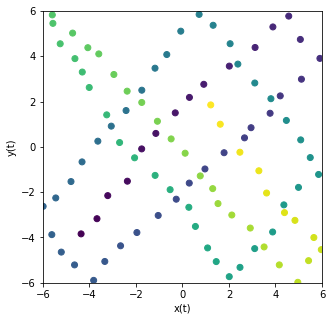

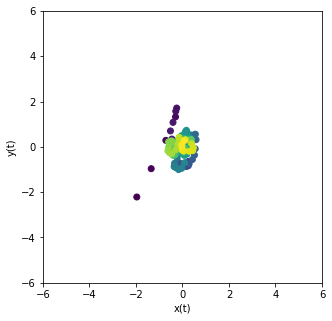

In [27]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)